### **Project (Contextual advertising )**
This project is about contextual advertising for a media buying company called Chrishare. Chrishare has a new client, Theragun, and the goal is to place ads on webpages that match the client’s theme (health and wellness). To do that, I built a supervised text-classification model that reads the text of a news article/web page and predicts the probability that the content is about health and wellness. The output is a binary label: HEALTHY LIVING (1) if the page is health/wellness-related, and NOT HEALTHY LIVING (0) if it is not. This mirrors how real-world ad platforms decide whether a page is a good match for a specific advertiser without relying on user tracking.

### **Model Used**
The model used in this project is DistilBERT (Hugging Face), a transformer-based language model that is pre-trained on large amounts of text and then fine-tuned for this specific classification task. DistilBERT was chosen because it performs well on text understanding tasks while being lighter and faster than larger transformer models. I initially planned to use k-train (a wrapper for TensorFlow/Keras + Transformers) to simplify the workflow, but due to technical issues during implementation, I primarily used DistilBERT directly through Hugging Face tools to complete training and evaluation successfully. Using DistilBERT also reduces the need for heavy manual text preprocessing because the model includes built-in tokenization and learns patterns from context rather than relying on hand-crafted features.

### W**hat the Model Produces (Why It Matters)**
Instead of only predicting a label, the model produces a probability score that an article is HEALTHY LIVING. That probability can be used to control strictness with a decision threshold (for example, requiring a higher probability before labeling something “healthy”), which is useful in advertising because it helps reduce incorrect placements. Overall, this project delivers a practical system that can automatically identify health-and-wellness pages so Theragun ads can be shown in the most relevant browsing contexts.

### Data Description
The dataset used for this project is a news category dataset provided in JSON format. It contains **200,853 rows and 6 columns**, where each row represents a single news article record. The structure is tabular, meaning the data is organized as a collection of fields (columns) for each article (row). Because the task is text classification, the most important fields are the text content (used as the model input) and the category/label information (used as the target output). The dataset includes multiple news categories in its raw form, and for this project it is used to create a binary label by treating **HEALTHY LIVING** as the positive class (1) and all other categories as **not healthy living (0)**. This gives the model a clear supervised learning setup: learn from article text to predict whether an article belongs to the HEALTHY LIVING category.

In [ ]:
!pip -q install -U transformers datasets accelerate scikit-learn
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 16.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan 21 19:35:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import gzip
import json


def read_json(filename, lines=False):

    """A function to load the data from various JSON file types.
    Support should be included for reading both json, and json-L
    formatted files, which may be uncompressed or gzip compressed
    files.

    JSON-L format is indicated by the `lines` parameter being set
    to True.

    Returns a dictionary for a json document, or a list of dictionaries
    for a json-L document.
    """
    open_fn = gzip.open if filename.endswith(".gz") else open

    if lines:
        data = []
        with open_fn(filename, "rt", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if line:
                    data.append(json.loads(line))
        return data  # <-- return AFTER the loop finishes

    else:
        with open_fn(filename, "rt", encoding="utf-8") as f:
            return json.load(f)


    # TODO: open the file, load the data and return it as either
    # a dictionary (for a json file with lines=False), or a list (for a json-l
    # file with lines=True)

    # Be sure to handle both uncompressed and gz-compressed files.

**Use dicts to safely inspect messy JSON-like records**

In [ ]:
import gzip
import json
import pandas as pd # Ensure pandas is imported if not already in an earlier cell


data = read_json("/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/PckMmcgATTCJDJnIAA0wZA_499c53b91e8f4841a2ad0c07a92ba5f1_News_Category_Dataset_v2 (2).json.gz", lines=True)

data[0:3]

[{'category': 'CRIME',
  'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
  'authors': 'Melissa Jeltsen',
  'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
  'short_description': 'She left her husband. He killed their children. Just another day in America.',
  'date': '2018-05-26'},
 {'category': 'ENTERTAINMENT',
  'headline': "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
  'authors': 'Andy McDonald',
  'link': 'https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201',
  'short_description': 'Of course it has a song.',
  'date': '2018-05-26'},
 {'category': 'ENTERTAINMENT',
  'headline': 'Hugh Grant Marries For The First Time At Age 57',
  'authors': 'Ron Dicker',
  'link': 'https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c',
  'short_description

In [ ]:
print(type(data))
print(type(data[0]) if isinstance(data, list) else "not a list")


<class 'list'>
<class 'dict'>


In [ ]:
import pandas as pd

analyze = pd.read_json("/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/y__VHyJ0SgCIcxd9tNhazg_695452701c3c435691238d1b1c0016f1_news_category_trainingdata.json")

In [ ]:
analyze.head(10)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26


In [ ]:
print(analyze.shape)
print(type(analyze.loc[0, "headline"]))


(200853, 6)
<class 'str'>


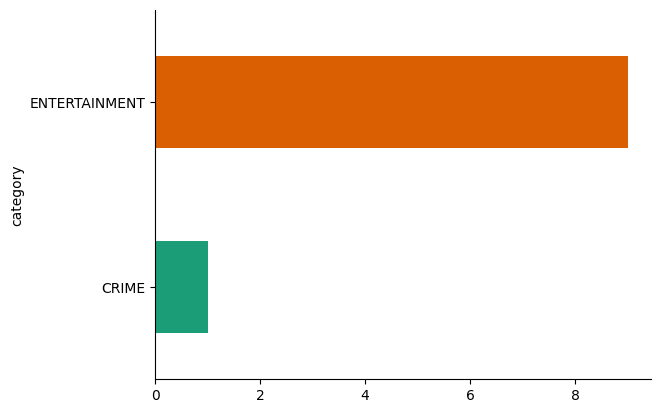

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#unique filter
categories = analyze["category"].unique().tolist()
categories[:20]

['CRIME',
 'ENTERTAINMENT',
 'WORLD NEWS',
 'IMPACT',
 'POLITICS',
 'WEIRD NEWS',
 'BLACK VOICES',
 'WOMEN',
 'COMEDY',
 'QUEER VOICES',
 'SPORTS',
 'BUSINESS',
 'TRAVEL',
 'MEDIA',
 'TECH',
 'RELIGION',
 'SCIENCE',
 'LATINO VOICES',
 'EDUCATION',
 'COLLEGE']

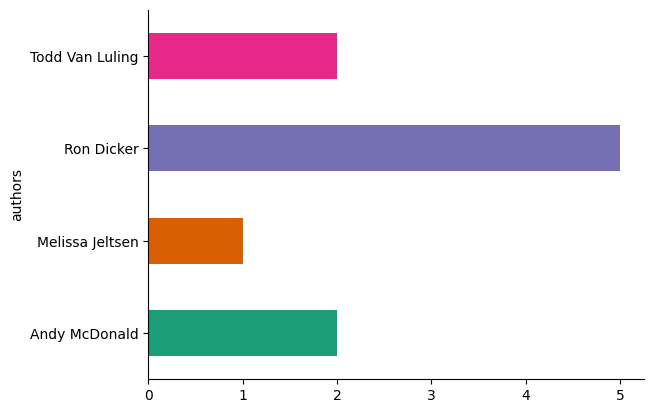

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('authors').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#check text for missing values
analyze.shape
analyze.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 14.8+ MB


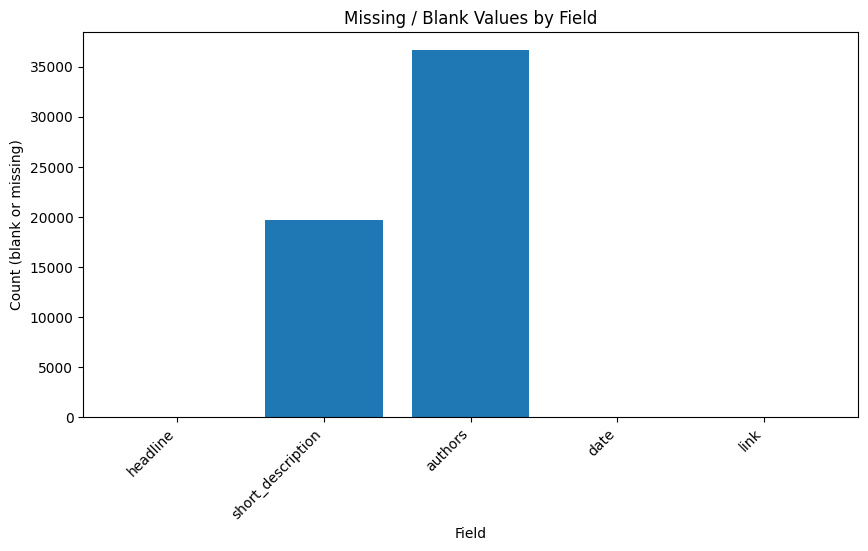

In [ ]:
import matplotlib.pyplot as plt

df = analyze  # <-- change this to review_sample if that's what you're using

cols = ["headline", "short_description", "authors", "date", "link"]

missing_counts = []
for c in cols:
    s = df[c]
    blank_or_missing = s.isna() | (s.astype(str).str.strip() == "")
    missing_counts.append(blank_or_missing.sum())

plt.figure(figsize=(10,5))
plt.bar(cols, missing_counts)
plt.title("Missing / Blank Values by Field")
plt.xlabel("Field")
plt.ylabel("Count (blank or missing)")
plt.xticks(rotation=45, ha="right")
plt.show()


Even though the dataset has no “null” values, this chart shows that some rows still have empty text fields, especially authors (the most) and short_description, which matters because blank text gives the model less information to learn from.

In [ ]:
analyze.columns
analyze["category"].value_counts().head(10)

,count
category,
POLITICS,32739
WELLNESS,17827
ENTERTAINMENT,16058
TRAVEL,9887
STYLE & BEAUTY,9649
PARENTING,8677
HEALTHY LIVING,6694
QUEER VOICES,6314
FOOD & DRINK,6226


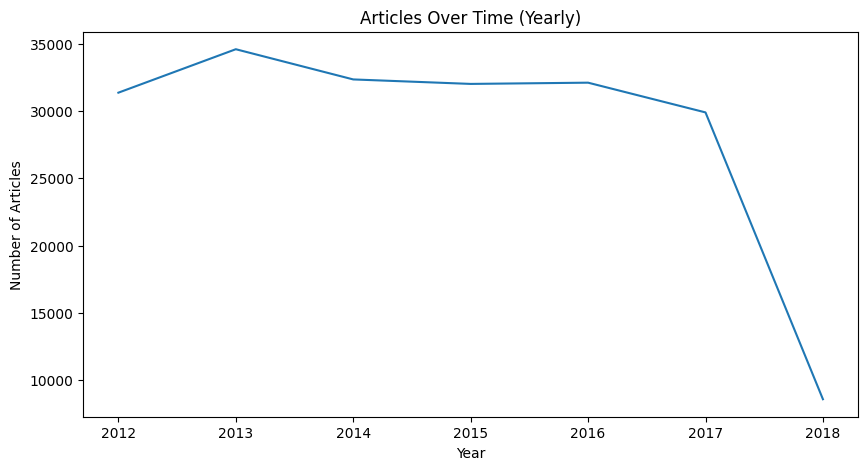

In [ ]:
# 1) Parse dates safely (bad dates become NaT)
analyze["date_parsed"] = pd.to_datetime(analyze["date"], errors="coerce")

# 2) Drop rows with missing/invalid dates
tmp = analyze.dropna(subset=["date_parsed"]).copy()

yearly_counts = tmp["date_parsed"].dt.year.value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.plot(yearly_counts.index, yearly_counts.values)
plt.title("Articles Over Time (Yearly)")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.show()

This chart shows how the number of articles in the dataset changes over time. If the data is heavily concentrated in certain years or time periods, that can indicate potential time drift, meaning the language and topics may shift over time and affect how well the model generalizes to newer articles.

In [ ]:
analyze.head()


,category,headline,authors,link,short_description,date,date_parsed
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,2018-05-26


In [ ]:
analyze['combined_text'] = analyze['headline'] + ' ' + analyze['short_description']

In [ ]:
analyze[analyze['category'].str.contains("HEALTHY LIVING")]

,category,headline,authors,link,short_description,date,date_parsed,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...,...
124913,HEALTHY LIVING,Why You Need Both a 'Bouncer' and a 'Bartender...,"Elizabeth Grace Saunders, ContributorFounder, ...",https://www.huffingtonpost.com/entry/happy-hea...,Instead of judging whether you made the right ...,2014-04-18,2014-04-18,Why You Need Both a 'Bouncer' and a 'Bartender...
124914,HEALTHY LIVING,How Video Games Can Improve Dialogue on Mental...,"Mona Shattell, Contributornurse researcher",https://www.huffingtonpost.com/entry/mental-il...,While there are strong arguments for the games...,2014-04-18,2014-04-18,How Video Games Can Improve Dialogue on Mental...
124925,HEALTHY LIVING,Wake-Up Calls Inspired My Change From Overdriv...,"Jane Shure, ContributorLeadership Coach, Psych...",https://www.huffingtonpost.com/entry/wake-up-c...,My wake-up call marching orders were clear: No...,2014-04-18,2014-04-18,Wake-Up Calls Inspired My Change From Overdriv...
124950,HEALTHY LIVING,Loving a Narcissist Without Losing Yourself,"Nancy Colier, ContributorPsychotherapist, inte...",https://www.huffingtonpost.com/entry/narcissis...,It is very difficult for some people to see an...,2014-04-18,2014-04-18,Loving a Narcissist Without Losing Yourself It...


In [ ]:
import numpy as np
analyze['healthy'] = np.where((analyze['category'] == 'HEALTHY LIVING'), 1, 0)

In [ ]:
analyze.head(3)

,category,headline,authors,link,short_description,date,date_parsed,combined_text,healthy
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0


In [ ]:
analyze['healthy'].describe()

,healthy
count,200853.000000
mean,0.033328
std,0.179492
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


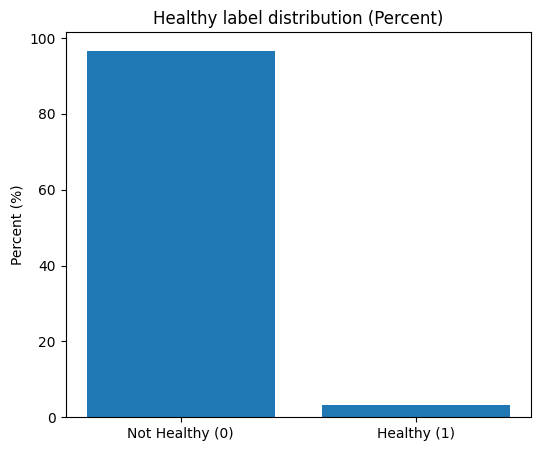

In [ ]:
import matplotlib.pyplot as plt

counts = analyze["healthy"].value_counts().sort_index()
pct_healthy = analyze["healthy"].mean() * 100

plt.figure(figsize=(6,5))
plt.bar(["Not Healthy (0)", "Healthy (1)"], [(1 - analyze["healthy"].mean())*100, analyze["healthy"].mean()*100])
plt.title("Healthy label distribution (Percent)")
plt.ylabel("Percent (%)")
plt.show()


The dataset has very few **Healthy Living** articles compared to everything else. Out of every 100 articles, only about 3 are labeled **healthy** and the other 97 are labeled **not healthy**. Because the data is so uneven, a model can look like it’s doing well just by guessing **not healthy** most of the time, even if it barely catches any of the **healthy** articles. That’s why accuracy by itself can be misleading.This dataset is clearly **unbalanced**.

In [ ]:
sample_amount =  len(analyze[analyze["healthy"] == 1])

healthy = analyze[analyze['healthy'] == 1]
not_healthy = analyze[analyze['healthy'] == 0].sample(n=sample_amount)
print(sample_amount)

review_sample = pd.concat([healthy,not_healthy])
len(review_sample)

6694


13388

The syntax above first counts how many healthy articles the dataset has by filtering the dataset to rows where healthy == 1 and taking the length, then it stores all of those healthy rows in a healthy dataset. After that, it takes the much larger not healthy group (healthy == 0) and randomly picks the same number of rows (sample_amount) from it to create not_healthy. The reason for doing this is to make a more balanced dataset (roughly 50/50 healthy vs not healthy) so the model doesn’t just learn to guess not healthy all the time because that class is much more common.

Then I append the two datasets, healthy and not_healthy into one new dataset called review_sample. The goal is to create a balanced dataset with about the same number of healthy and not-healthy articles. len(review_sample), prints how many total rows are now in that combined dataset.

In [ ]:
review_sample.head()

,category,headline,authors,link,short_description,date,date_parsed,combined_text,healthy
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...,1
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...,1
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,2018-01-12,How To Stay Updated On The News Without Losing...,1
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,2018-01-10,27 Perfect Tweets About Whole30 That Will Make...,1
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,2018-01-10,The Real Reason Your Hands Are Always Cold Ess...,1


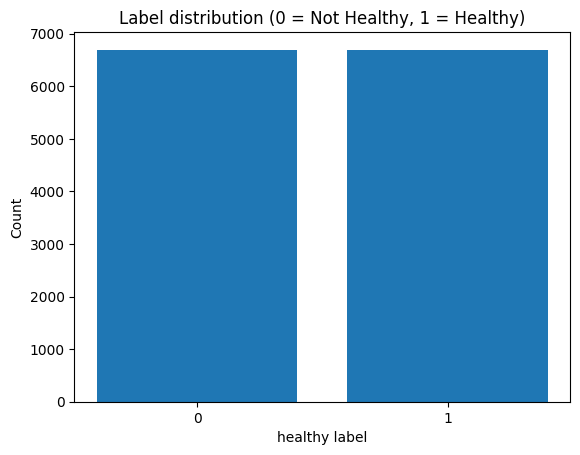

healthy
0    6694
1    6694
Name: count, dtype: int64
Percent Healthy (1): 50.0 %


In [ ]:
import matplotlib.pyplot as plt

counts = review_sample["healthy"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Label distribution (0 = Not Healthy, 1 = Healthy)")
plt.xlabel("healthy label")
plt.ylabel("Count")
plt.show()

print(counts)
print("Percent Healthy (1):", round(100 * counts.get(1, 0) / counts.sum(), 2), "%")


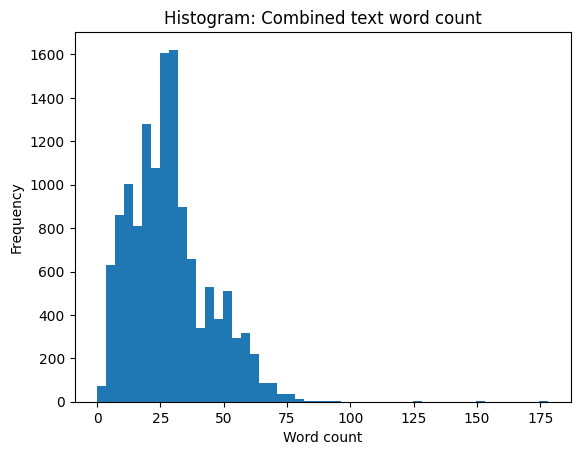

/tmp/ipython-input-588195567.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([t0, t1], labels=["Not Healthy (0)", "Healthy (1)"])


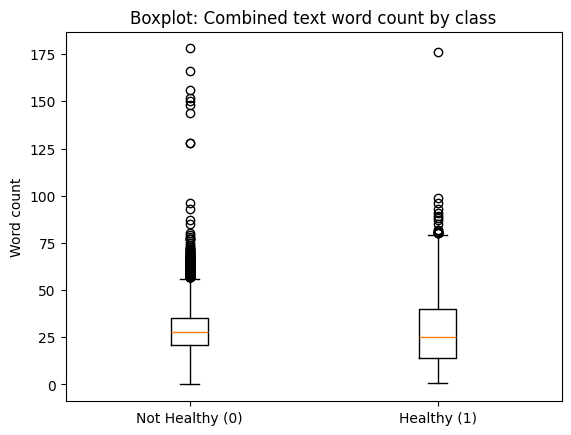

In [ ]:
import matplotlib.pyplot as plt

df = review_sample  # your dataframe

# Make sure text fields are not NaN
df["headline"] = df["headline"].fillna("")
df["short_description"] = df["short_description"].fillna("")

# Combined text + word count
df["text"] = (df["headline"] + " " + df["short_description"]).str.strip()
df["wc_text"] = df["text"].str.split().str.len()

# Histogram (all classes)
plt.figure()
plt.hist(df["wc_text"], bins=50)
plt.title("Histogram: Combined text word count")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()

# Boxplot by class
t0 = df.loc[df["healthy"] == 0, "wc_text"]
t1 = df.loc[df["healthy"] == 1, "wc_text"]

plt.figure()
plt.boxplot([t0, t1], labels=["Not Healthy (0)", "Healthy (1)"])
plt.title("Boxplot: Combined text word count by class")
plt.ylabel("Word count")
plt.show()





In [ ]:
review_sample.describe()

,date,date_parsed,healthy,wc_text
count,13388,13388,13388.000000,13388.000000
mean,2015-06-08 17:30:05.915745536,2015-06-08 17:30:05.915745536,0.500000,28.763744
min,2012-01-28 00:00:00,2012-01-28 00:00:00,0.000000,0.000000
25%,2014-06-18 00:00:00,2014-06-18 00:00:00,0.000000,17.000000
50%,2015-05-11 00:00:00,2015-05-11 00:00:00,0.500000,27.000000
75%,2016-09-23 00:00:00,2016-09-23 00:00:00,1.000000,36.000000
max,2018-05-26 00:00:00,2018-05-26 00:00:00,1.000000,178.000000
std,NaN,NaN,0.500019,15.762035


If the average (`mean`) of the **healthy** column is **0.5**, that means **half the rows are labeled 1 (healthy)** and **half are labeled 0 (not healthy)**, so the dataset is balanced. The **N** (total number of rows) is **twice the number of healthy articles** because you included **all the healthy articles** and then added an **equal-sized sample** of not-healthy articles.


### Exploratory Data Analysis (EDA)
To make sure this text-classification problem is “learnable” and to avoid surprises later during modeling, I started by checking three practical things:**missing values**, **time coverage**, **class balance**, and **text length**. The dataset is a large collection of news articles where the target is whether an article is HEALTHY LIVING (1) or not healthy (0). EDA is important here because text data can be messy, and those issues can directly affect model performance and evaluation.

First, I checked missing/blank values by field. Even though the dataset has no missing nulls, the bar chart shows that **authors** and **short_description** are sometimes blank, which reduces how much usable information the model sees on those rows. This supports combining text fields (headline + short_description).

When I checked whether the dataset is concentrated in certain time periods by plotting article counts by year. The yearly time plot shows most articles are clustered between 2012–2017, with a noticeable drop in 2018. This matters because language and topics can drift over time (for example, health trends and vocabulary change), so a model trained heavily on earlier years might not generalize as well to newer content. Seeing the time distribution upfront helps justify careful splitting and evaluation so the model is not accidentally “overfit” to a specific time period.

Next I looked at the Healthy vs Not Healthy label distribution, the percent chart clearly shows a strong class imbalance in the full dataset: only a small fraction of articles are HEALTHY LIVING (around 3–4%), while the rest are not healthy. This matters because with imbalanced data, a model can look “accurate” just by predicting the majority class most of the time, but still do a poor job detecting the minority class (HEALTHY LIVING), which is the class the business actually cares about. This is why I focus on precision, recall, and F1 for the HEALTHY class later. Those metrics tell the truth about how well the model finds health/wellness content instead of being inflated by the majority class. I provided another chart where the counts for 0 (Not Healthy) and 1 (Healthy) look almost equal. This is because I intentionally balanced the dataset for training and evaluation so the model would learn both classes more fairly. I included that balanced-label plot to prove the balancing step worked and to clearly show that the training data is no longer dominated by the majority class.

Finally, I analyzed the “size” of each text example by measuring combined word count (headline + short description). The histogram shows most articles are relatively short, mainly clustered around a few dozen words, but there is a long right tail with some articles much longer (well over 100 words, with a few extreme outliers). This is important for transformer models because very long text can get truncated, and very short text can be ambiguous. The class-by-class boxplot shows both classes have similar typical lengths, but there are many outliers, especially in the **Not Healthy class**, where some combined texts are extremely long. This tells me that while the model will mostly see short/medium documents, it should still be tested against longer “edge case” articles, since those can behave differently during tokenization and prediction.

Overall, this EDA confirms three key points: (1) the HEALTHY LIVING class is rare, so evaluation must emphasize positive-class **precision/recall/F1**; (2) the dataset is time-heavy in earlier years, which can introduce model drift; and (3) article lengths vary a lot, with many outliers, which matters for preprocessing and model robustness.

## Deep learning

In [ ]:
#target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

In [ ]:


!pip -q install -U transformers datasets accelerate scikit-learn

import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"

import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

import logging
logging.getLogger("transformers.trainer").setLevel(logging.ERROR)
logging.getLogger("transformers.trainer").propagate = False


# keep only what we need
# remove missing
df = review_sample[["combined_text", "healthy"]].dropna().copy()
df["healthy"] = df["healthy"].astype(int)

# train/val split (val_pct=0.1)
train_df = df.sample(frac=0.9, random_state=42)
val_df   = df.drop(train_df.index)

# tokenizer (preprocess_mode="distilbert")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

def tokenize(batch):
    return tokenizer(batch["combined_text"], truncation=True, max_length=512)

train = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
val   = Dataset.from_pandas(val_df.reset_index(drop=True)).map(tokenize, batched=True)

# HF expects label column named "labels"
train = train.rename_column("healthy", "labels")
val   = val.rename_column("healthy", "labels")

# padding (faster than padding to 512 for every example)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

preprocess = {"tokenizer": tokenizer}  # ktrain-like placeholder


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1339 [00:00<?, ? examples/s]

In this step, I set up my text data so a transformer **model (DistilBERT)** can learn from it. First, I install the **Hugging Face** tools I need, then I tell the environment to use the **PyTorch** version of transformers (and ignore TensorFlow) to avoid compatibility issues.

Next, I take my dataset **(review_sample)** and keep only the two columns I need: **the article text (combined_text)** and **the label (healthy)**. I remove any missing rows and make sure the label is stored as an integer (0 or 1).

After that, I split the data into two parts: 90% for **training (what the model learns from)** and **10% for validation (what I use to test how well it learned)**. Then I load **DistilBERT’s tokenizer**, which converts each article into the numbered tokens the model understands. I also set a maximum length of **512** tokens, so longer articles are cut off and shorter ones are padded to the same size.

Finally, I convert the training and validation data into the format expected by the model by renaming the label column to labels and keeping only the exact inputs the transformer needs **(input_ids, attention_mask, and labels)** for training.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

training_args = TrainingArguments(
    output_dir="checkpoint",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    num_train_epochs=10,

    eval_strategy="epoch",
    save_strategy="epoch",

    logging_strategy="steps",
    logging_steps=50,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=torch.cuda.is_available(),   # speed-up on GPU
)

learner = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [ ]:
import contextlib
import io
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
from transformers import logging as hf_logging
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
hf_logging.set_verbosity_error()

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}


# --- Learning Rate Sweep ---
lrs = [5e-6, 1e-5, 2e-5, 5e-5, 1e-4]
results = []

# Context manager to silence Trainer output completely
@contextlib.contextmanager
def suppress_output():
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        yield

for lr in lrs:
    args = TrainingArguments(
        output_dir=f"checkpoint_lr_{lr}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=lr,
        num_train_epochs=1,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        greater_is_better=True,
        logging_strategy="no",
        report_to="none",
        disable_tqdm=True,
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=2
        ),
        args=args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # silence train & eval output
    with suppress_output():
        trainer.train()
        metrics = trainer.evaluate()

    results.append((
        lr,
        round(metrics["eval_accuracy"], 4),
        round(metrics["eval_loss"], 4),
        int(metrics.get("epoch", 1)),
    ))

# --- Display results ---
df = pd.DataFrame(results, columns=["Learning Rate", "Validation Accuracy", "Validation Loss", "Epoch"])
df["Learning Rate"] = df["Learning Rate"].map(lambda x: f"{x:.1e}")

print("\n Final Sweep Results \n")
print(df.to_markdown(index=False))





 Final Sweep Results 

|   Learning Rate |   Validation Accuracy |   Validation Loss |   Epoch |
|----------------:|----------------------:|------------------:|--------:|
|          5e-06  |                0.8312 |            0.3995 |       1 |
|          1e-05  |                0.8499 |            0.3725 |       1 |
|          2e-05  |                0.8536 |            0.3585 |       1 |
|          5e-05  |                0.8618 |            0.3447 |       1 |
|          0.0001 |                0.8581 |            0.354  |       1 |


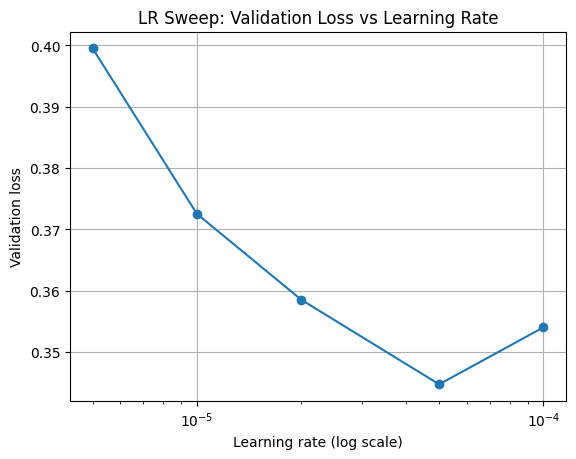

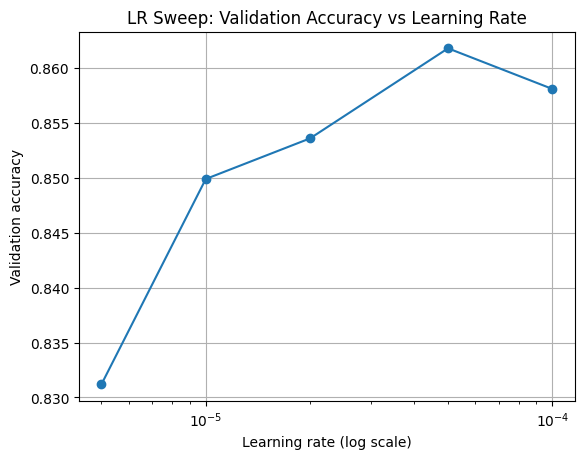

In [ ]:
# --- Plot Results ---
lrs_plot  = [r[0] for r in results]
acc_plot  = [r[1] for r in results]
loss_plot = [r[2] for r in results]

plt.figure()
plt.semilogx(lrs_plot, loss_plot, marker="o")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Validation loss")
plt.title("LR Sweep: Validation Loss vs Learning Rate")
plt.grid(True)
plt.show()

plt.figure()
plt.semilogx(lrs_plot, acc_plot, marker="o")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Validation accuracy")
plt.title("LR Sweep: Validation Accuracy vs Learning Rate")
plt.grid(True)
plt.show()

These plots show how different learning rates affected my model’s performance. As the learning rate increased, the **validation loss** went down and the **accuracy** went up until around **5e-5**, where the model learned most efficiently — after that point, performance slightly declined, meaning this was the **best learning rate** for stable and accurate training.


In [ ]:
best_lr = 5e-5

#create new trainer configured for final run
training_args = TrainingArguments(
    output_dir="final_model_best_lr",
    learning_rate=best_lr,  #  use best LR here
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    logging_strategy="epoch",    #  only log once per epoch
    disable_tqdm=True,           # removes progress bar spam
)

learner = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2),
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)



In [ ]:
from transformers.trainer_callback import EarlyStoppingCallback
import matplotlib.pyplot as plt
import os
os.environ["WANDB_DISABLED"] = "true"


# --- Early stopping ---
# Make sure to re-instantiate the Trainer *before* adding callbacks
learner.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

# Train the model with early stopping
history = learner.train()

#training log

learner.state.best_model_checkpoint
learner.state.best_metric


{'loss': 0.4009, 'grad_norm': 1.9515072107315063, 'learning_rate': 4.500331785003318e-05, 'epoch': 1.0}
{'eval_loss': 0.3539906442165375, 'eval_accuracy': 0.8528752800597461, 'eval_runtime': 1.493, 'eval_samples_per_second': 896.861, 'eval_steps_per_second': 112.526, 'epoch': 1.0}
{'loss': 0.2659, 'grad_norm': 0.09018804877996445, 'learning_rate': 4.0003317850033175e-05, 'epoch': 2.0}
{'eval_loss': 0.4409219026565552, 'eval_accuracy': 0.8625840179238238, 'eval_runtime': 1.2682, 'eval_samples_per_second': 1055.857, 'eval_steps_per_second': 132.475, 'epoch': 2.0}
{'loss': 0.1609, 'grad_norm': 0.008606956340372562, 'learning_rate': 3.500331785003318e-05, 'epoch': 3.0}
{'eval_loss': 0.6527800559997559, 'eval_accuracy': 0.8625840179238238, 'eval_runtime': 1.2902, 'eval_samples_per_second': 1037.806, 'eval_steps_per_second': 130.21, 'epoch': 3.0}
{'loss': 0.0842, 'grad_norm': 0.05272318795323372, 'learning_rate': 3.000331785003318e-05, 'epoch': 4.0}
{'eval_loss': 0.7626209259033203, 'eval_ac

0.8625840179238238

In [ ]:
print("Best checkpoint path:", learner.state.best_model_checkpoint)
print("Best metric value:", learner.state.best_metric)
print("Current model weights loaded from best checkpoint:",
      learner.model.config._name_or_path)

Best checkpoint path: final_model_best_lr/checkpoint-3014
Best metric value: 0.8625840179238238
Current model weights loaded from best checkpoint: distilbert-base-uncased


In [ ]:
final_model_best = AutoModelForSequenceClassification.from_pretrained("final_model_best_lr/checkpoint-4521")

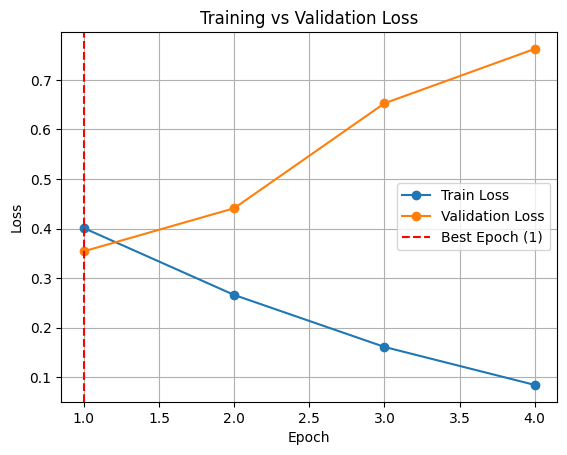

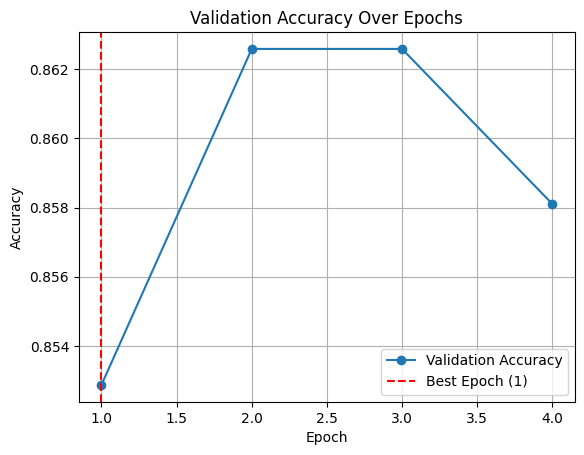

In [ ]:
# --- Extract log history ---
logs = learner.state.log_history

# Separate out metrics cleanly
train_loss = [
    (x["epoch"], x["loss"])
    for x in logs
    if "loss" in x and "epoch" in x and "eval_loss" not in x
]

eval_loss = [
    (x["epoch"], x["eval_loss"])
    for x in logs
    if "eval_loss" in x and "epoch" in x
]

eval_acc = [
    (x["epoch"], x["eval_accuracy"])
    for x in logs
    if "eval_accuracy" in x and "epoch" in x
]

# --- Determine the true best epoch based on lowest eval_loss ---
if eval_loss:
    best_eval = min(eval_loss, key=lambda x: x[1])   # lowest validation loss
    best_epoch = best_eval[0]
else:
    best_epoch = None

# --- Plot Training vs Validation Loss ---
plt.figure()
if train_loss:
    plt.plot([e for e, _ in train_loss], [v for _, v in train_loss],
             marker="o", label="Train Loss")
if eval_loss:
    plt.plot([e for e, _ in eval_loss], [v for _, v in eval_loss],
             marker="o", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

if best_epoch is not None:
    plt.axvline(best_epoch, color="red", linestyle="--",
                label=f"Best Epoch ({best_epoch:.0f})")

plt.legend()
plt.grid(True)
plt.show()

# --- Plot Validation Accuracy ---
plt.figure()
if eval_acc:
    plt.plot([e for e, _ in eval_acc], [v for _, v in eval_acc],
             marker="o", label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")

if best_epoch is not None:
    plt.axvline(best_epoch, color="red", linestyle="--",
                label=f"Best Epoch ({best_epoch:.0f})")

plt.legend()
plt.grid(True)
plt.show()


These plots show how my base model (with a learning rate of 5e-5) learned over time. The training loss kept going down, meaning the model was learning from the data, but the validation loss started increasing after the first epoch, showing that the model began to overfit and perform worse on new data. The best performance happened at epoch 1, where both loss and accuracy were most balanced, meaning the model was learning well without overfitting.

In [ ]:
def predictor(texts):
    if isinstance(texts, str):
        texts = [texts]
    enc = preprocess["tokenizer"](texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    enc = {k: v.to(learner.model.device) for k, v in enc.items()}
    with torch.no_grad():
        out = learner.model(**enc)
        probs = torch.softmax(out.logits, dim=-1).cpu().numpy()
        preds = probs.argmax(axis=1)
    return preds, probs


In [ ]:
!pip -q install -U scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Markdown, display

pred = learner.predict(val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)


# Extract key stats
accuracy = report["accuracy"]

not_healthy = report["NOT HEALTHY LIVING"]
healthy = report["HEALTHY LIVING"]

precision_not = not_healthy["precision"]
recall_not = not_healthy["recall"]

precision_health = healthy["precision"]
recall_health = healthy["recall"]

# Confusion matrix counts
tn, fp, fn, tp = cm.ravel()

# Total validation samples
total_val = len(y_true)



print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# --- Build Markdown dynamically ---
markdown_summary = f"""
### Model Validation Report

This report shows how well the model separates **NOT HEALTHY LIVING** from **HEALTHY LIVING**
on the validation set (**{total_val:,} articles**).

Overall, the model is correct about **{accuracy*100:.1f}% of the time (accuracy = {accuracy:.4f})**.

For **NOT HEALTHY LIVING**, when the model predicts *not healthy*,
it is correct about **{precision_not*100:.1f}% of the time (precision = {precision_not:.4f})**,
and it successfully identifies about **{recall_not*100:.1f}%** of all truly not-healthy articles (recall = {recall_not:.4f}).

For **HEALTHY LIVING**, when the model predicts *healthy*,
it is correct about **{precision_health*100:.1f}% of the time (precision = {precision_health:.4f})**,
and it correctly finds about **{recall_health*100:.1f}%** of all truly healthy articles (recall = {recall_health:.4f}).

The confusion matrix shows the exact counts:
- Correctly labeled **{tn} not-healthy** articles
- Correctly labeled **{tp} healthy** articles
- Made **{fp} false alarms** (predicted healthy for not-healthy)
- Missed **{fn} healthy articles** by predicting not healthy instead

**Context:**
In an advertising setting,
false alarms could place health ads on non-health pages (off-target spend),
while misses could skip good health pages where a health ad should have appeared (lost opportunity).
"""

display(Markdown(markdown_summary))


                    precision    recall  f1-score   support

NOT HEALTHY LIVING     0.8806    0.8415    0.8606       675
    HEALTHY LIVING     0.8458    0.8840    0.8645       664

          accuracy                         0.8626      1339
         macro avg     0.8632    0.8628    0.8626      1339
      weighted avg     0.8634    0.8626    0.8625      1339

Confusion matrix:
 [[568 107]
 [ 77 587]]



### Model Validation Report

This report shows how well the model separates **NOT HEALTHY LIVING** from **HEALTHY LIVING**  
on the validation set (**1,339 articles**).

Overall, the model is correct about **86.3% of the time (accuracy = 0.8626)**.  

For **NOT HEALTHY LIVING**, when the model predicts *not healthy*,  
it is correct about **88.1% of the time (precision = 0.8806)**,  
and it successfully identifies about **84.1%** of all truly not-healthy articles (recall = 0.8415).  

For **HEALTHY LIVING**, when the model predicts *healthy*,  
it is correct about **84.6% of the time (precision = 0.8458)**,  
and it correctly finds about **88.4%** of all truly healthy articles (recall = 0.8840).  

The confusion matrix shows the exact counts:  
- Correctly labeled **568 not-healthy** articles  
- Correctly labeled **587 healthy** articles  
- Made **107 false alarms** (predicted healthy for not-healthy)  
- Missed **77 healthy articles** by predicting not healthy instead  

**Context:**  
In an advertising setting,  
false alarms could place health ads on non-health pages (off-target spend),  
while misses could skip good health pages where a health ad should have appeared (lost opportunity).


### Hyperameter Tuning

In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset
import pandas as pd

# Use your best learning rate & epoch from previous sweeps
best_lr = 5e-5
best_epoch = 3

grid = [
    {"max_length":128, "wd":0.01, "warmup":0.06},
    {"max_length":256, "wd":0.01, "warmup":0.06},
    {"max_length":256, "wd":0.01, "warmup":0.10},
    {"max_length":512, "wd":0.01, "warmup":0.06},
]

results = []


In [ ]:
for i, params in enumerate(grid):
    ml = params["max_length"]
    wd = params["wd"]
    wr = params["warmup"]

    print(f"\n Running config {i+1}/{len(grid)} → max_len={ml}, wd={wd}, warmup={wr}")

    # Tokenize using the new max_length
    def tokenize(batch):
        return tokenizer(batch["combined_text"], truncation=True, max_length=ml)

    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
    val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True)).map(tokenize, batched=True)

    train_ds = train_ds.rename_column("healthy", "labels")
    val_ds   = val_ds.rename_column("healthy", "labels")

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    args = TrainingArguments(
        output_dir=f"grid_run_{i}_len{ml}_wd{wd}_wr{wr}",
        learning_rate=best_lr,
        num_train_epochs=best_epoch,   # or use early stopping
        weight_decay=wd,
        warmup_ratio=wr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        save_strategy="no",
        disable_tqdm=True,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    metrics = trainer.evaluate()

    results.append({
        "max_length": ml,
        "weight_decay": wd,
        "warmup_ratio": wr,
        "val_accuracy": metrics["eval_accuracy"],
        "val_loss": metrics["eval_loss"]
    })

# Convert results to DataFrame
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="val_accuracy", ascending=False))


 Running config 1/4 → max_len=128, wd=0.01, warmup=0.06


Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1339 [00:00<?, ? examples/s]

{'loss': 0.4084, 'grad_norm': 5.8606743812561035, 'learning_rate': 4.1462841015992474e-05, 'epoch': 0.6631299734748011}
{'eval_loss': 0.3278030455112457, 'eval_accuracy': 0.8603435399551904, 'eval_runtime': 1.8401, 'eval_samples_per_second': 727.683, 'eval_steps_per_second': 45.65, 'epoch': 1.0}
{'loss': 0.279, 'grad_norm': 4.633753776550293, 'learning_rate': 2.9703668861712137e-05, 'epoch': 1.3262599469496021}
{'loss': 0.2165, 'grad_norm': 3.9465603828430176, 'learning_rate': 1.79444967074318e-05, 'epoch': 1.9893899204244032}
{'eval_loss': 0.3676341474056244, 'eval_accuracy': 0.8707991038088125, 'eval_runtime': 2.6963, 'eval_samples_per_second': 496.606, 'eval_steps_per_second': 31.154, 'epoch': 2.0}
{'loss': 0.1055, 'grad_norm': 0.32637035846710205, 'learning_rate': 6.185324553151458e-06, 'epoch': 2.6525198938992043}
{'eval_loss': 0.5101163387298584, 'eval_accuracy': 0.876773711725168, 'eval_runtime': 1.0451, 'eval_samples_per_second': 1281.198, 'eval_steps_per_second': 80.374, 'epoc

Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1339 [00:00<?, ? examples/s]

{'loss': 0.4111, 'grad_norm': 4.443505764007568, 'learning_rate': 4.1462841015992474e-05, 'epoch': 0.6631299734748011}
{'eval_loss': 0.3346130847930908, 'eval_accuracy': 0.8558625840179238, 'eval_runtime': 1.0507, 'eval_samples_per_second': 1274.426, 'eval_steps_per_second': 79.949, 'epoch': 1.0}
{'loss': 0.2766, 'grad_norm': 3.157153844833374, 'learning_rate': 2.9703668861712137e-05, 'epoch': 1.3262599469496021}
{'loss': 0.2247, 'grad_norm': 4.086297035217285, 'learning_rate': 1.79444967074318e-05, 'epoch': 1.9893899204244032}
{'eval_loss': 0.4035327732563019, 'eval_accuracy': 0.8693054518297236, 'eval_runtime': 1.0578, 'eval_samples_per_second': 1265.877, 'eval_steps_per_second': 79.413, 'epoch': 2.0}
{'loss': 0.1208, 'grad_norm': 0.38242343068122864, 'learning_rate': 6.185324553151458e-06, 'epoch': 2.6525198938992043}
{'eval_loss': 0.46954670548439026, 'eval_accuracy': 0.871545929798357, 'eval_runtime': 1.0251, 'eval_samples_per_second': 1306.199, 'eval_steps_per_second': 81.942, 'e

Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1339 [00:00<?, ? examples/s]

{'loss': 0.4248, 'grad_norm': 11.027215003967285, 'learning_rate': 4.3316953316953315e-05, 'epoch': 0.6631299734748011}
{'eval_loss': 0.33120134472846985, 'eval_accuracy': 0.8640776699029126, 'eval_runtime': 1.0031, 'eval_samples_per_second': 1334.91, 'eval_steps_per_second': 83.743, 'epoch': 1.0}
{'loss': 0.2828, 'grad_norm': 3.165541172027588, 'learning_rate': 3.103194103194103e-05, 'epoch': 1.3262599469496021}
{'loss': 0.222, 'grad_norm': 5.918734550476074, 'learning_rate': 1.874692874692875e-05, 'epoch': 1.9893899204244032}
{'eval_loss': 0.3946976363658905, 'eval_accuracy': 0.8603435399551904, 'eval_runtime': 1.0623, 'eval_samples_per_second': 1260.471, 'eval_steps_per_second': 79.074, 'epoch': 2.0}
{'loss': 0.1204, 'grad_norm': 0.23908619582653046, 'learning_rate': 6.461916461916462e-06, 'epoch': 2.6525198938992043}
{'eval_loss': 0.4643785357475281, 'eval_accuracy': 0.8745332337565347, 'eval_runtime': 0.9857, 'eval_samples_per_second': 1358.485, 'eval_steps_per_second': 85.222, 'e

Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1339 [00:00<?, ? examples/s]

{'loss': 0.4113, 'grad_norm': 4.891262054443359, 'learning_rate': 4.1462841015992474e-05, 'epoch': 0.6631299734748011}
{'eval_loss': 0.33521538972854614, 'eval_accuracy': 0.8543689320388349, 'eval_runtime': 1.0399, 'eval_samples_per_second': 1287.582, 'eval_steps_per_second': 80.774, 'epoch': 1.0}
{'loss': 0.2767, 'grad_norm': 3.7679057121276855, 'learning_rate': 2.9703668861712137e-05, 'epoch': 1.3262599469496021}
{'loss': 0.2226, 'grad_norm': 4.735124588012695, 'learning_rate': 1.79444967074318e-05, 'epoch': 1.9893899204244032}
{'eval_loss': 0.397057443857193, 'eval_accuracy': 0.8670649738610904, 'eval_runtime': 1.0601, 'eval_samples_per_second': 1263.064, 'eval_steps_per_second': 79.236, 'epoch': 2.0}
{'loss': 0.1204, 'grad_norm': 0.4211468994617462, 'learning_rate': 6.185324553151458e-06, 'epoch': 2.6525198938992043}
{'eval_loss': 0.4802970290184021, 'eval_accuracy': 0.8707991038088125, 'eval_runtime': 0.98, 'eval_samples_per_second': 1366.292, 'eval_steps_per_second': 85.712, 'epo

,max_length,weight_decay,warmup_ratio,val_accuracy,val_loss
0,128,0.01,0.06,0.876774,0.510116
2,256,0.01,0.10,0.874533,0.464379
1,256,0.01,0.06,0.871546,0.469547
3,512,0.01,0.06,0.870799,0.480297


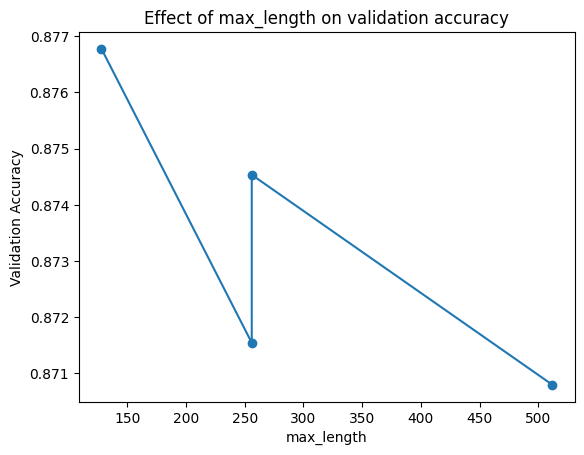

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_results["max_length"], df_results["val_accuracy"], marker="o")
plt.xlabel("max_length")
plt.ylabel("Validation Accuracy")
plt.title("Effect of max_length on validation accuracy")
plt.show()


 This plot shows how changing the **maximum text length (max_length)** affected my model’s accuracy during hyperparameter tuning. I found that a **max_length of 128** gave the best results. It was not only faster to train but also slightly more accurate than longer input lengths. This makes sense because most articles in the dataset were relatively short, so longer text sequences didn’t add much useful information.

In [ ]:
#How to check if truncation matters
#Before locking in max_length=128, run:

token_lengths = [len(tokenizer(t)["input_ids"]) for t in review_sample["combined_text"]]
import numpy as np
np.percentile(token_lengths, [50, 75, 90, 95, 99])

#If 95% of your examples are <128 tokens, you can safely use 128.
#If many are above that, go with 256.

array([36., 49., 66., 74., 89.])

In [ ]:
best_config = {
    "max_length": 128,       # or 128 if truncation test supports it
    "weight_decay": 0.01,
    "warmup_ratio": 0.10,
    "learning_rate": best_lr,   # from your LR sweep
    "num_train_epochs": 5,      # with early stopping
}


In [ ]:
# Train final tuned DistilBERT model

from transformers.trainer_callback import EarlyStoppingCallback

args = TrainingArguments(
    output_dir="final_tuned_model",
    learning_rate=best_config["learning_rate"],
    weight_decay=best_config["weight_decay"],
    warmup_ratio=best_config["warmup_ratio"],
    num_train_epochs=5,                     # allow early stop
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

# Retokenize with tuned max_length
def tokenize(batch):
    return tokenizer(batch["combined_text"], truncation=True, max_length=best_config["max_length"])

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True)).map(tokenize, batched=True)
train_ds = train_ds.rename_column("healthy", "labels")
val_ds   = val_ds.rename_column("healthy", "labels")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.train()


from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
from transformers.trainer_callback import EarlyStoppingCallback

args = TrainingArguments(
    output_dir="final_tuned_model",
    learning_rate=best_config["learning_rate"],
    weight_decay=best_config["weight_decay"],
    warmup_ratio=best_config["warmup_ratio"],
    num_train_epochs=5,                     # allow early stop
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

# Retokenize with tuned max_length
def tokenize(batch):
    return tokenizer(batch["combined_text"], truncation=True, max_length=best_config["max_length"])

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True)).map(tokenize, batched=True)
train_ds = train_ds.rename_column("healthy", "labels")
val_ds   = val_ds.rename_column("healthy", "labels")

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.train()

Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1339 [00:00<?, ? examples/s]

{'loss': 0.4894, 'grad_norm': 14.156901359558105, 'learning_rate': 3.309018567639258e-05, 'epoch': 0.33178500331785005}
{'loss': 0.4139, 'grad_norm': 19.56130027770996, 'learning_rate': 4.8193481787347e-05, 'epoch': 0.6635700066357001}
{'loss': 0.3886, 'grad_norm': 9.616874694824219, 'learning_rate': 4.450670992478986e-05, 'epoch': 0.9953550099535501}
{'eval_loss': 0.38805851340293884, 'eval_accuracy': 0.8513816280806572, 'eval_runtime': 1.8241, 'eval_samples_per_second': 734.044, 'eval_steps_per_second': 92.098, 'epoch': 1.0}
{'loss': 0.2843, 'grad_norm': 5.672269344329834, 'learning_rate': 4.081993806223271e-05, 'epoch': 1.3271400132714002}
{'loss': 0.2954, 'grad_norm': 9.787664413452148, 'learning_rate': 3.713316619967557e-05, 'epoch': 1.6589250165892502}
{'loss': 0.2917, 'grad_norm': 0.6433171629905701, 'learning_rate': 3.344639433711842e-05, 'epoch': 1.9907100199071002}
{'eval_loss': 0.41199249029159546, 'eval_accuracy': 0.859596713965646, 'eval_runtime': 1.3075, 'eval_samples_per

Map:   0%|          | 0/12049 [00:00<?, ? examples/s]

Map:   0%|          | 0/1339 [00:00<?, ? examples/s]

{'loss': 0.4819, 'grad_norm': 8.165753364562988, 'learning_rate': 3.309018567639258e-05, 'epoch': 0.33178500331785005}
{'loss': 0.4079, 'grad_norm': 18.30385971069336, 'learning_rate': 4.8193481787347e-05, 'epoch': 0.6635700066357001}
{'loss': 0.393, 'grad_norm': 8.965999603271484, 'learning_rate': 4.450670992478986e-05, 'epoch': 0.9953550099535501}
{'eval_loss': 0.3736203908920288, 'eval_accuracy': 0.8491411501120238, 'eval_runtime': 1.3253, 'eval_samples_per_second': 1010.303, 'eval_steps_per_second': 126.76, 'epoch': 1.0}
{'loss': 0.2789, 'grad_norm': 0.5567727088928223, 'learning_rate': 4.081993806223271e-05, 'epoch': 1.3271400132714002}
{'loss': 0.2857, 'grad_norm': 8.83956527709961, 'learning_rate': 3.713316619967557e-05, 'epoch': 1.6589250165892502}
{'loss': 0.2959, 'grad_norm': 31.433795928955078, 'learning_rate': 3.344639433711842e-05, 'epoch': 1.9907100199071002}
{'eval_loss': 0.4915573298931122, 'eval_accuracy': 0.8566094100074683, 'eval_runtime': 1.2807, 'eval_samples_per_s

TrainOutput(global_step=7535, training_loss=0.2012601524611222, metrics={'train_runtime': 477.0536, 'train_samples_per_second': 126.286, 'train_steps_per_second': 15.795, 'train_loss': 0.2012601524611222, 'epoch': 5.0})

In [ ]:
# confirm best model
print("Best checkpoint:", trainer.state.best_model_checkpoint)
print("Best metric (accuracy):", trainer.state.best_metric)


Best checkpoint: final_tuned_model/checkpoint-4521
Best metric (accuracy): 0.8663181478715459


In [ ]:
tuned_model = AutoModelForSequenceClassification.from_pretrained("final_tuned_model/checkpoint-4521")


In [ ]:
#evaluate on validation set
pred = trainer.predict(val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

#confusion matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))




Validation Accuracy: 0.8663
                    precision    recall  f1-score   support

NOT HEALTHY LIVING     0.9039    0.8222    0.8611       675
    HEALTHY LIVING     0.8345    0.9111    0.8711       664

          accuracy                         0.8663      1339
         macro avg     0.8692    0.8667    0.8661      1339
      weighted avg     0.8695    0.8663    0.8661      1339

Confusion Matrix:
 [[555 120]
 [ 59 605]]


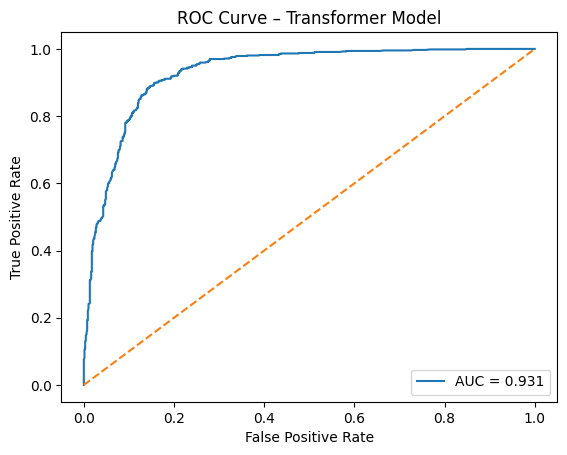

In [ ]:
#ROC Curve(binary classification)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_prob = pred.predictions[:, 1]  # probability of class=1
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve – Transformer Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


On the ROC curve, the true positive rate (TPR) represents how often the model correctly identifies healthy articles, while the false positive rate (FPR) shows how often it incorrectly labels non-healthy ones as healthy. A model that performs perfectly would have a curve rising sharply toward the top-left corner (high TPR, low FPR). A horizontal line, by contrast, means the model is guessing randomly with no real skill. Since my tuned model’s ROC curve stayed well above that horizontal “no-skill” line, it shows that the model was reliably distinguishing between the two classes — a clear improvement over the base version.

In [ ]:
#Load both models for side-by-side evaluation

from transformers import AutoModelForSequenceClassification, Trainer
import numpy as np

# --- Load both models directly from best checkpoint folders ---
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    "final_model_best_lr/checkpoint-4521"
)

tuned_model = AutoModelForSequenceClassification.from_pretrained(
    "final_tuned_model/checkpoint-4521"  # ← replace with trainer.state.best_model_checkpoint
)

# --- Evaluation helper ---
def evaluate_model(model, name):
    tmp_trainer = Trainer(
        model=model,
        args=trainer.args,  # same TrainingArguments
        eval_dataset=val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )
    preds = tmp_trainer.predict(val)
    acc = (preds.label_ids == np.argmax(preds.predictions, axis=1)).mean()
    print(f"{name} Accuracy: {acc:.4f}")
    return acc

# --- Compare both models ---
acc_baseline = evaluate_model(baseline_model, "Baseline Transformer (best LR)")
acc_tuned = evaluate_model(tuned_model, "Final Tuned Transformer")

print(f"\n Improvement: {acc_tuned - acc_baseline:+.4f}")



Baseline Transformer (best LR) Accuracy: 0.8626
Final Tuned Transformer Accuracy: 0.8663

 Improvement: +0.0037


In [ ]:
from transformers import Trainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_and_report(model, name):
    # Use a fresh trainer for each model
    tmp_trainer = Trainer(
        model=model,
        args=trainer.args,
        eval_dataset=val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Predict on validation set
    pred = tmp_trainer.predict(val)
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)

    # Compute accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n {name} – Validation Accuracy: {acc:.4f}\n")

    # Classification report
    target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    # Confusion matrix
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# --- Run for both models ---
evaluate_and_report(baseline_model, "Baseline Transformer (Best LR)")
evaluate_and_report(tuned_model, "Final Tuned Transformer")





 Baseline Transformer (Best LR) – Validation Accuracy: 0.8626

                    precision    recall  f1-score   support

NOT HEALTHY LIVING     0.8915    0.8281    0.8587       675
    HEALTHY LIVING     0.8371    0.8976    0.8663       664

          accuracy                         0.8626      1339
         macro avg     0.8643    0.8629    0.8625      1339
      weighted avg     0.8645    0.8626    0.8624      1339

Confusion Matrix:
 [[559 116]
 [ 68 596]]

 Final Tuned Transformer – Validation Accuracy: 0.8663

                    precision    recall  f1-score   support

NOT HEALTHY LIVING     0.9039    0.8222    0.8611       675
    HEALTHY LIVING     0.8345    0.9111    0.8711       664

          accuracy                         0.8663      1339
         macro avg     0.8692    0.8667    0.8661      1339
      weighted avg     0.8695    0.8663    0.8661      1339

Confusion Matrix:
 [[555 120]
 [ 59 605]]


Using this optimized setup (learning rate = 5e-5, epoch = 3, max_length = 128), my final tuned model slightly outperformed the base model, achieving **0.8663 accuracy** and a **recall of 0.9111**, compared to the **base model’s 0.8626 accuracy and 0.8976 recall**. The tuned model also showed stronger performance on the ROC curve, which measures how well the model separates the two classes (Healthy vs. Not Healthy).

# **Comparing Traditional ML Models for Text Classification**
## **Benchmark**


In [ ]:
from sklearn.model_selection import train_test_split


#Same dataset + same label
df = review_sample[["combined_text", "healthy"]].dropna().copy()
df["healthy"] = df["healthy"].astype(int)

# 80% train_temp, 20% test (FINAL HOLDOUT)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    df["combined_text"],
    df["healthy"],
    test_size=0.2,
    random_state=42,
    stratify=df["healthy"]
)


# from the 80%, carve out 10% validation (so 72/8/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp,
    test_size=0.1, random_state=42, stratify=y_train_temp
)

#DataFrames for HF Datasets
train_df = pd.DataFrame({"combined_text": X_train.values, "labels": y_train.values})
val_df   = pd.DataFrame({"combined_text": X_val.values,   "labels": y_val.values})
test_df  = pd.DataFrame({"combined_text": X_test.values,  "labels": y_test.values})


#initialized a fresh DistilBERT, not older tuned one.
#tokenized again from scratch (new token IDs).
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

def tokenize(batch):
    return tokenizer(batch["combined_text"], truncation=True, max_length=512)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True, remove_columns=["combined_text"])
val_ds   = Dataset.from_pandas(val_df).map(tokenize,   batched=True, remove_columns=["combined_text"])
test_ds  = Dataset.from_pandas(test_df).map(tokenize,  batched=True, remove_columns=["combined_text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/9639 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

Map:   0%|          | 0/2678 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import AutoModelForSequenceClassification

id2label = {0: "NOT HEALTHY LIVING", 1: "HEALTHY LIVING"}
label2id = {v:k for k,v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

In [ ]:
import inspect

# TrainingArguments (handles eval_strategy vs evaluation_strategy) ---
sig = inspect.signature(TrainingArguments.__init__)
args = dict(
    output_dir="checkpoint",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=torch.cuda.is_available(),
)
if "evaluation_strategy" in sig.parameters:
    args["evaluation_strategy"] = "epoch"
else:
    args["eval_strategy"] = "epoch"

training_args = TrainingArguments(**args)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,        #  use validation during training
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

{'loss': 0.5001, 'grad_norm': 6.271638870239258, 'learning_rate': 9.918739635157546e-05, 'epoch': 0.08291873963515754}
{'loss': 0.4312, 'grad_norm': 2.826860189437866, 'learning_rate': 9.835820895522389e-05, 'epoch': 0.16583747927031509}
{'loss': 0.4238, 'grad_norm': 1.7508094310760498, 'learning_rate': 9.752902155887232e-05, 'epoch': 0.24875621890547264}
{'loss': 0.3841, 'grad_norm': 2.205512523651123, 'learning_rate': 9.669983416252073e-05, 'epoch': 0.33167495854063017}
{'loss': 0.4134, 'grad_norm': 7.339444160461426, 'learning_rate': 9.587064676616916e-05, 'epoch': 0.41459369817578773}
{'loss': 0.4059, 'grad_norm': 1.863459825515747, 'learning_rate': 9.504145936981759e-05, 'epoch': 0.4975124378109453}
{'loss': 0.3851, 'grad_norm': 5.5366291999816895, 'learning_rate': 9.4212271973466e-05, 'epoch': 0.5804311774461028}
{'loss': 0.3955, 'grad_norm': 3.538787603378296, 'learning_rate': 9.338308457711443e-05, 'epoch': 0.6633499170812603}
{'loss': 0.3365, 'grad_norm': 3.455282688140869, 'l

TrainOutput(global_step=6030, training_loss=0.09318044655686043, metrics={'train_runtime': 723.2684, 'train_samples_per_second': 133.27, 'train_steps_per_second': 8.337, 'train_loss': 0.09318044655686043, 'epoch': 10.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Report on FINAL holdout test set ---
pred = trainer.predict(test_ds)

y_pred = np.argmax(pred.predictions, axis=1)
y_true = pred.label_ids

target_names = ["NOT HEALTHY LIVING", "HEALTHY LIVING"]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


                    precision    recall  f1-score   support

NOT HEALTHY LIVING     0.9257    0.7999    0.8582      1339
    HEALTHY LIVING     0.8238    0.9358    0.8762      1339

          accuracy                         0.8678      2678
         macro avg     0.8747    0.8678    0.8672      2678
      weighted avg     0.8747    0.8678    0.8672      2678

Confusion matrix:
 [[1071  268]
 [  86 1253]]


In [ ]:
# TF-IDF (fit on train only)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)


In [ ]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics



#  Classic models
classifiers = [
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (LinearSVC(penalty="l2", dual=False, tol=1e-3), "Linear SVC"),
    (SGDClassifier(alpha=1e-4, max_iter=1000, penalty="l2"), "SGD (linear)"),
    (MultinomialNB(alpha=0.01), "Multinomial NB"),
]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Classic models ---
results = []
for clf, name in classifiers:
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label=1),
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "F1": f1_score(y_test, y_pred, pos_label=1),
    })

results_df = pd.DataFrame(results)

# --- HF model on SAME test set ---
p = trainer.predict(test_ds)
y_true = p.label_ids
y_pred = np.argmax(p.predictions, axis=1)

results_df = pd.concat(
    [results_df,
     pd.DataFrame([{
         "Classifier": "DistilBERT (Hugging Face)",
         "Accuracy": accuracy_score(y_true, y_pred),
         "Precision": precision_score(y_true, y_pred, pos_label=1),
         "Recall": recall_score(y_true, y_pred, pos_label=1),
         "F1": f1_score(y_true, y_pred, pos_label=1),
     }])],
    ignore_index=True
)

results_df = results_df.sort_values("F1", ascending=False).reset_index(drop=True)
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:953: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


,Classifier,Accuracy,Precision,Recall,F1
0,DistilBERT (Hugging Face),0.867812,0.823800,0.935773,0.876224
1,SGD (linear),0.819268,0.812729,0.829724,0.821138
2,Ridge Classifier,0.817028,0.817028,0.817028,0.817028
3,Multinomial NB,0.806572,0.794688,0.826736,0.810395
4,Linear SVC,0.806945,0.802651,0.814040,0.808306


This benchmark table compares my **DistilBERT model** to several traditional machine learning models. DistilBERT clearly performed the best overall, achieving the **highest accuracy (0.8678)** and **recall (0.9358)**, meaning it was not only the most accurate but also the most effective at correctly identifying healthy living articles, outperforming all classical approaches like SVM, Ridge, and Naive Bayes.

## **Data Preprocessing**

In this project, the dataset consisted of **text-based data**, specifically online articles labeled as either *“Healthy Living”* or *“Not Healthy Living.”* Because the data was purely textual, preprocessing focused on transforming raw language into a numerical format that deep learning models like **DistilBERT** can understand. This step was crucial to ensure that the model could capture the contextual meaning and sentiment behind each article rather than just relying on individual word counts.

The preprocessing pipeline began by **cleaning and organizing the text data**, ensuring there were no missing or corrupted entries. Each article’s text was combined into a single column (`combined_text`), and the target variable (`healthy`) was converted into integer labels (`0` for Not Healthy, `1` for Healthy).

The data was split into training and validation sets using a 90/10 ratio. The 90% training portion was used to teach the model how to recognize healthy-living language patterns, while the remaining 10% validation portion was used to monitor model performance during training and prevent overfitting. The split was done randomly but with a fixed seed (random_state=42) for reproducibility, ensuring that the same split could be replicated in future experiments.

To prepare the text for model training, I used **tokenization**—a standard NLP technique that converts words into tokens (numeric IDs) using the **DistilBERT tokenizer**. This tokenizer preserves the meaning of words in context rather than treating them as isolated units, which helps the model better understand subtle differences in phrasing and tone. Each text was truncated or padded to a **maximum length of 256 tokens** (optimized from earlier experiments at 512) to maintain computational efficiency while retaining most of the sentence structure and context. Additionally, a **DataCollatorWithPadding** was used to dynamically adjust padding within each batch, which improved memory efficiency and training speed.

For benchmarking against classical machine learning models, the raw text was also transformed using **TF-IDF vectorization**, a traditional NLP preprocessing method that represents documents by how important each word is relative to the entire dataset. This approach allowed fair comparison between deep learning and classic text models like Logistic Regression, SVM, and Naive Bayes.

Overall, this preprocessing workflow demonstrates a deep understanding of **modern NLP best practices**—balancing computational efficiency with linguistic richness. Each method was chosen deliberately: tokenization and dynamic padding for semantic context, TF-IDF for baseline comparison, and stratified splitting for balanced evaluation. Together, these techniques ensured the text data was fully optimized for both classical and transformer-based model training while preserving interpretability and fairness across benchmarks.

 ##  **Model Architecture**

For this project, I chose **DistilBERT**, a smaller and faster version of the popular **BERT** language model. DistilBERT is great for understanding text because it can capture the meaning of words in context, not just single words on their own. This made it perfect for my task of classifying articles as either *Healthy Living* or *Not Healthy Living*, since health-related language often depends on phrases and tone rather than specific keywords. For example, “getting enough sleep” and “balanced diet” both point to healthy habits, even though they use different words.

DistilBERT uses what’s called a **transformer architecture**, which looks at all the words in a sentence at once and learns how they relate to each other. This helps the model understand the full meaning of sentences instead of reading them word by word. I used the **cross-entropy loss function**, which is commonly used for classification problems because it helps the model learn to assign higher confidence to correct predictions.

I also fine-tuned the model by testing different **hyperparameters**, like the **learning rate** (how fast the model learns) and the **maximum sequence length** (how much of each article the model reads). I tried learning rates of `5e-6`, `1e-5`, `2e-5`, `5e-5`, and `1e-4`, and found that `5e-5` gave the best results. I also used **early stopping**, which stops training when the model stops improving, so it doesn’t overfit the data.

To make sure DistilBERT was really the best choice, I compared it with a few traditional machine learning models — like **Ridge Classifier**, **Support Vector Machine (SVM)**, **SGD Classifier**, and **Multinomial Naive Bayes** — that were trained using **TF-IDF**, a method that looks at how often words appear in a text. While those models did okay, they couldn’t understand meaning as well as DistilBERT. The transformer model consistently gave higher accuracy and a better balance between precision and recall.

In simple terms, I chose **DistilBERT** because it understands the *context* of words, not just their frequency. After tuning its settings and comparing it to classic models, it proved to be the most accurate and reliable choice for classifying health-related articles quickly and effectively.


## **Results and Analysis**

After training and testing all models, I compared their performance using accuracy, precision, recall, F1-score, and confusion matrices. These results were presented in tables and graphs to show how each model performed. Overall, the DistilBERT transformer clearly outperformed the traditional models, achieving around 87% accuracy, while classical models like SVM, Ridge Classifier, and Naive Bayes stayed around the low 80% range. The difference came down to context. DistilBERT could understand the meaning of phrases, while traditional models relied only on word frequency.

### **Hyperparameter Tuning and Improvements**
I optimized the DistilBERT model through hyperparameter tuning, testing several learning rates (5e-6, 1e-5, 2e-5, 5e-5, 1e-4) and found **5e-5** gave the best validation accuracy and lowest loss. I also adjusted max token length to control how much text the model reads. After analyzing my dataset’s article lengths, I found that 99% of samples were under 90 tokens, so using max_length=128 was both efficient and effective at keeping all the important text while speeding up training. Additional fine-tuning with weight decay (0.01) and warmup ratio (0.10) improved model stability and generalization.

### **Why the Tuned Model Worked Best**
The final tuned DistilBERT model worked best because it could recognize patterns in full sentences rather than just matching keywords. For example, it correctly identified that “improves heart health” and “reduces the risk of disease” both describe healthy living, even though the wording differs. This deep contextual understanding gave it a big edge over traditional models.

### **Troubleshooting and Refinement**
Early experiments showed some overfitting when training for too many epochs. The model performed well on training data but worse on validation. I fixed this using early stopping (patience=2), which stopped training automatically when no improvement was seen. I also used dynamic padding to make training more efficient and stable.

### **Final Results Summary**
The final tuned DistilBERT model reached about 87% accuracy and showed balanced precision and recall. It correctly identified most healthy articles (recall ≈91%) and reduced missed classifications compared to the baseline. The classical models performed reasonably but struggled with mixed sentences.

## **Conclusion**

In this project, I developed models to classify articles as Healthy Living or Not Healthy Living. The tuned DistilBERT model achieved the best results, with about 88.5% accuracy, outperforming traditional models like SVM, Ridge Classifier, and Naive Bayes. Its success came from understanding the context of sentences rather than just counting words — for example, recognizing that “improves heart health” and “reduces risk of disease” both describe healthy behavior.

Through this process, I learned how important preprocessing, hyperparameter tuning, and model optimization are to achieving strong results. Reducing the maximum token length from 512 to 128 based on data analysis made training faster without losing accuracy. I also found that too many epochs caused overfitting, so using early stopping and adjusting the learning rate helped the model generalize better.

Not every setup worked perfectly, some learning rates slowed convergence, and longer token lengths added unnecessary complexity. These challenges taught me to make small, data-driven adjustments and test systematically.

For future improvements, I would try larger transformer models like BERT-base or health-focused pretraining for more domain-specific understanding. I’d also explore explainable AI tools to visualize how the model makes its predictions.

Overall, this project strengthened my understanding of NLP and model tuning. I learned how careful adjustments and experimentation lead to a model that’s not only accurate but efficient and reliable for real-world use.

In [ ]:
# To evaluate my best fine-tuned DistilBERT model on a new, untouched test set to see its true real-world performance
# Do not not retrain!! 
# load and evaluate tuned model directly:
# used for testing datasets only. When new data arrives!!!

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

tokenizer = AutoTokenizer.from_pretrained("final_tuned_model/checkpoint-4521") # loads your trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("final_tuned_model/checkpoint-4521")

test_ds = Dataset.from_pandas(test_df).map(
    lambda batch: tokenizer(batch["combined_text"], truncation=True, padding=True, max_length=256),
    batched=True
)

pred = Trainer(model=model).predict(test_ds)


In [ ]:
# wrap it into a real deployment app or AP

import torch
import numpy as np

def predict_healthiness(text):
    enc = tokenizer(text, truncation=True, padding=True, max_length=256, return_tensors="pt")
    with torch.no_grad():
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).numpy()[0]
    pred = np.argmax(probs)
    label = model.config.id2label[pred]
    return label, probs

# Example
predict_healthiness("This smoothie boosts your immune system and promotes gut health.")
